In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Load necessary packages/libraries

In [2]:
import json, sys, random
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from keras.utils import to_categorical

Using TensorFlow backend.


Download and study the dataset

In [3]:
# download dataset from json object
f = open(r'../input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(f)
f.close()

input_data = np.array(dataset['data']).astype('uint8')
labels_data = np.array(dataset['labels']).astype('uint8')

The dataset contains 4000 images. 
Each image is represented as a vector of length 19200 elements, containing 3 layers (R,G & B) and 80x80 of weight and height:

In [4]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X.shape

(4000, 3, 80, 80)

Changing the RGB layers to the last dimension:

In [5]:
Xt=X.transpose(0,2,3,1)
Xt.shape

(4000, 80, 80, 3)

Displaying each layer RGB for the 100th image:

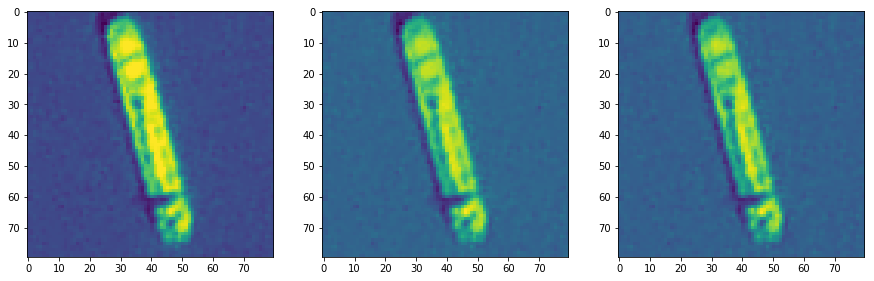

In [6]:
plt.figure( figsize = (15,15))

# show each channel
for i in range(0,3):
    plt.subplot(1, 3, (i+1))
    plt.imshow(Xt[100,:,:,i])

Dsiplaying the RGB image for the first 20 images:

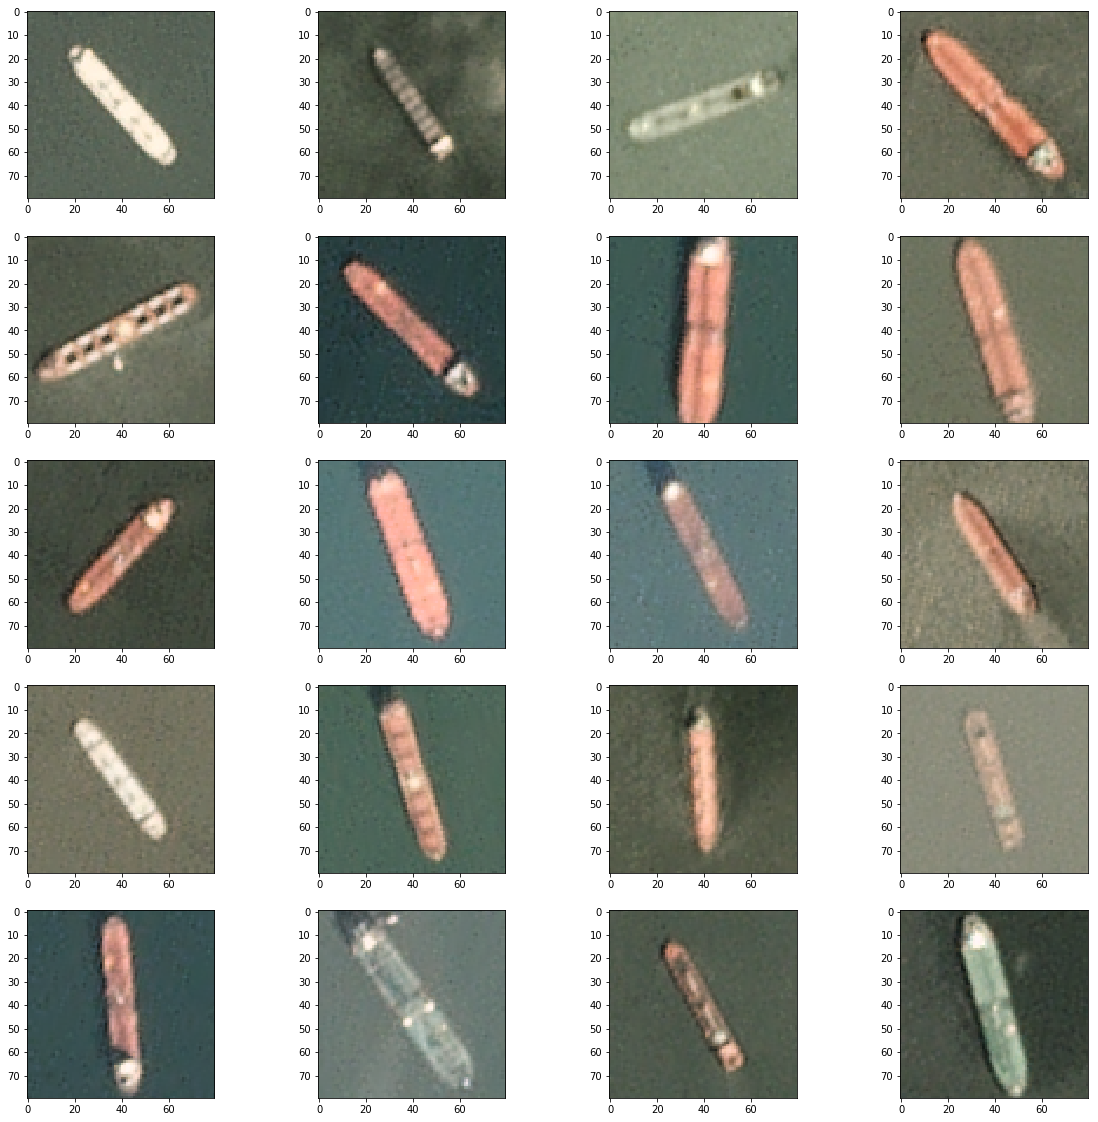

In [7]:
plt.figure( figsize = (20,20))

# show each channel
for i in range(0,20):
    plt.subplot(5, 4, (i+1))
    plt.imshow(Xt[i,:,:,:])



The dataset contains of 1000 images without ships (labelled with 0) and 3000 images with ships (labelled with 1): 

In [8]:
Presence_Absence=pd.value_counts(pd.Series(labels_data))
Presence_Absence

0    3000
1    1000
dtype: int64

Splitting the dataset into Train, Validation and Test:

In [9]:
# Create train set
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data,
    labels_data,
    test_size=.45, random_state=0, stratify=labels_data)

# Create validation and test sets
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test,test_size=.20, random_state=0)

data_train=data_train.reshape(-1, n_spectrum, weight, height)
data_test=data_test.reshape(-1, n_spectrum, weight, height)
data_validation=data_validation.reshape(-1, n_spectrum, weight, height)

print('Train:',data_train.shape, labels_train.shape)
print('Test:', data_test.shape, labels_test.shape)
print('Validation:', data_validation.shape, labels_validation.shape)

Train: (2200, 3, 80, 80) (2200,)
Test: (360, 3, 80, 80) (360,)
Validation: (1440, 3, 80, 80) (1440,)


Permute the dimensions of each array:

In [10]:
data_t_train=data_train.transpose(0,2,3,1)
data_t_test=data_test.transpose(0,2,3,1)
data_t_validation=data_validation.transpose(0,2,3,1)

Choosing the Number of Components in a PCA for the dataset:

Text(0.5, 1.0, 'PCA')

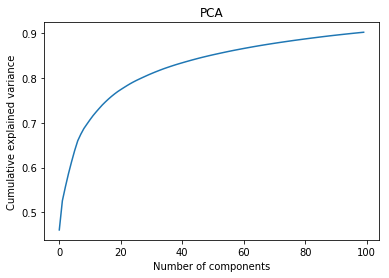

In [11]:
pca = PCA(n_components=100)
values_train=data_train.reshape(-1,(80*80*3))
pca.fit(values_train)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')



80 components would be enought to retain most of the dataset information:

In [12]:
NCOMPONENTS = 80

pca = PCA(n_components=NCOMPONENTS)


data_pca_train = pca.fit_transform(data_train.reshape(-1,(80*80*3)))
data_pca_val = pca.transform(data_validation.reshape(-1,(80*80*3)))
data_pca_test = pca.transform(data_test.reshape(-1,(80*80*3)))
pca_std = np.std(data_pca_train)


Convert the labels vectors from integers to binary class matrices:

In [13]:
labels_train=to_categorical(labels_train)
labels_test=to_categorical(labels_test)
labels_validation=to_categorical(labels_validation)

In [14]:
print(data_pca_val.shape)
print(labels_validation.shape)

(1440, 80)
(1440, 2)


FCNN model calibration:

In [15]:
model_fcnn = Sequential([
  Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001),input_shape=(80,)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)),
])

model_fcnn.summary()


model_fcnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model_fcnn.fit(
  data_pca_train, # training data
  labels_train, # training targets
  validation_data=(data_pca_val, labels_validation),
  epochs=100,
  batch_size=200
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                5184      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

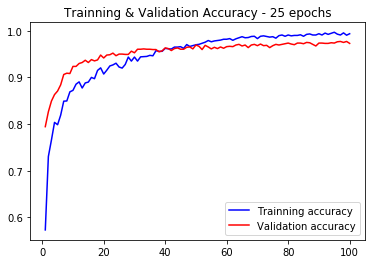

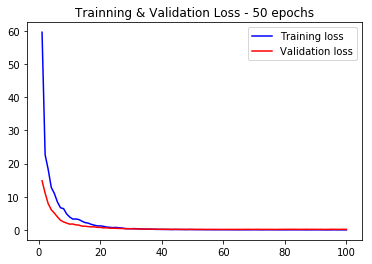

360/360 [==============================] - 0s 36us/step
Test loss 0.19
Test accuracy 0.98


In [16]:
acc=model_fcnn.history.history['accuracy']
val_acc=model_fcnn.history.history['val_accuracy']
loss=model_fcnn.history.history['loss']
val_loss=model_fcnn.history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Trainning accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Trainning & Validation Accuracy - 25 epochs')
plt.legend()
plt.figure()
plt.plot(epochs,loss, 'b', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='Validation loss')
plt.title('Trainning & Validation Loss - 50 epochs')
plt.legend()
plt.show()


test_loss, test_acc =model_fcnn.evaluate(
  data_pca_test,
  labels_test
)

print('Test loss', round(test_loss,2))
print('Test accuracy', round(test_acc,2))

Label prediction for the test dataset:

In [17]:
prediction=model_fcnn.predict_classes(data_pca_test)

Displaying the first 100 images from the test dataset overlaying the test labels as well as the predicted labels with the FCNN model:

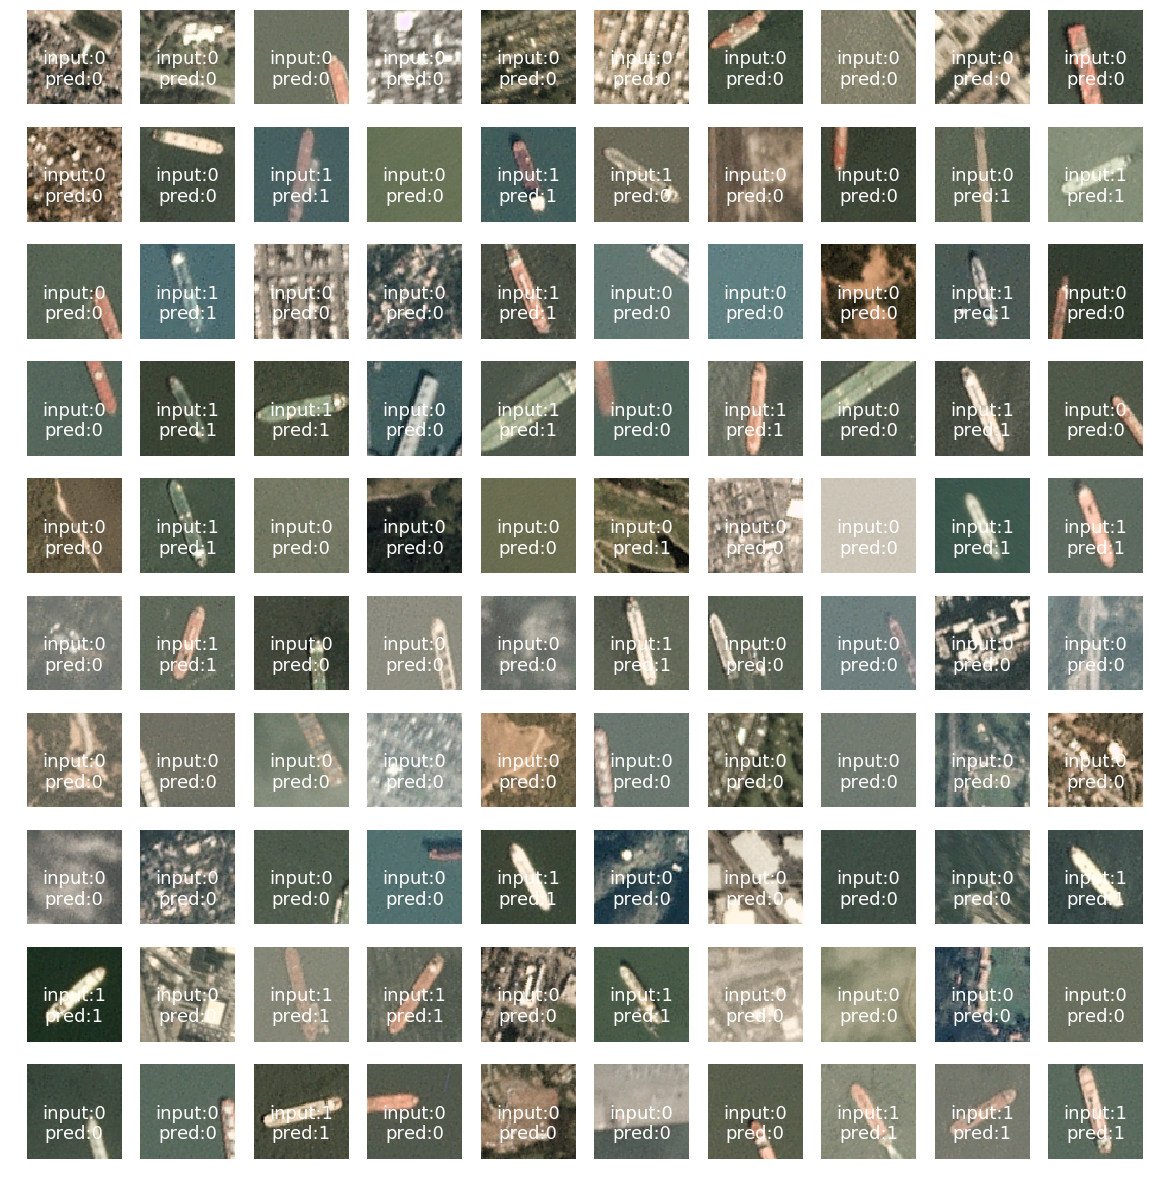

In [18]:
fig=plt.figure(figsize=(20, 20))

random.randint(0,len(data_test))

data_t_test=data_test.transpose(0,2,3,1)
# show each channel
for i in range(0,100):
    fig.add_subplot(10, 10, i+1)
    fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.2)
    plt.imshow(data_t_test[i,:,:,:])
    plt.title('input:'+str(labels_test.argmax(axis = 1)[i])+'\npred:'+str(prediction[i]), fontsize=18, y=.15,color='w')
    plt.axis('off')
plt.show()